In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



e:\User\PC\ads_enefit_ueh\ads_enfit


In [2]:
from libs.common import *
from config.config import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


e:/User/PC/ads_enefit_ueh/ads_enfit


In [3]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [4]:
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [5]:
wandb.init(project="enefit_prediction_consumer")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [6]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)


In [7]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


In [8]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_cnn_gru_no_weights.weights.h5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1,  # Hiển thị thông báo khi lưu model
    save_format="tf"
)

In [10]:
class CNNEncoding:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.feature = None
        self.model = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x = Conv1D(32, 3, activation='relu')(inputs)
        x = MaxPooling1D(2)(x)
        x = Flatten()(x)
        x = Dense(64, activation='relu')(x)
        self.features = Dense(16, activation='relu')(x)
        output = Dense(1, activation='linear')(x)
        
        model = Model(inputs, output, name='model1')
        return model
input_shape=(len(X.columns),1)
cnn_model=CNNEncoding(input_shape=input_shape)
# cnn_model.model.load_weights('weights/cnn.hdf5')
cnn_model.model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                102464    
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                            

In [11]:
class GRUClassification:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self.build_model()
        
    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x = GRU(units=64)(inputs)  # Adjust units and other parameters as needed
        x = Dropout(0.2)(x)
        x = Dense(units=32, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(units=1, activation='linear')(x)
        model = Model(inputs, outputs, name='model2')
        return model
input_dim=(16,1)
GRU_classification = GRUClassification(input_shape=input_dim)
GRU_classification.model.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14977 (58.50 KB)
Trainable params: 14977 (58.5

In [12]:
# GRU_classification.model.load_weights('weights/gru.hdf5')


In [13]:
class CNN_GRU:
    def __init__(self, input_shape,encoder, classification, lr=0.0001):
        self.input_shape = input_shape
        self.model1 = encoder.model
        self.feature_shape = (encoder.features.shape[1],)
        self.features=encoder.features
        self.model2 = classification.model
        self.lr = lr
        self.model = self.build_model()
        
    def build_model(self):
        combined_input = self.model1.input
        output = self.model2(self.features)
        combined_model = Model(inputs=combined_input, outputs=output, name='combined_model')
        combined_model.compile(optimizer=Adam(learning_rate=self.lr), loss='mae', metrics=['mae', r2])
        return combined_model

In [14]:
model =CNN_GRU(input_shape=input_shape,encoder=cnn_model, classification=GRU_classification).model
model.summary()


Model: "combined_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                102464    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                    

In [15]:
model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[wandb.keras.WandbCallback(metric_aliases={'mae': 'mean_absolute_error','r2':'r2','val_mae':'val_mean_absolute_error', 'val_r2':'val_r2'}),early_stopping,lr_scheduler,checkpoint_callback])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1306 - mae: 0.1306 - r2: 0.6937INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best)... Done. 0.2s



Epoch 1: val_loss improved from inf to 0.12547, saving model to best_model_cnn_gru_no_weights.weights.h5
16982/16982 [==============================] - 332s 19ms/step - loss: 0.1306 - mae: 0.1306 - r2: 0.6937 - val_loss: 0.1255 - val_mae: 0.1255 - val_r2: 0.7983 - lr: 1.0000e-04
Epoch 2/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.1167 - mae: 0.1167 - r2: 0.7261INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best)... Done. 0.1s



Epoch 2: val_loss improved from 0.12547 to 0.10544, saving model to best_model_cnn_gru_no_weights.weights.h5
16982/16982 [==============================] - 326s 19ms/step - loss: 0.1167 - mae: 0.1167 - r2: 0.7261 - val_loss: 0.1054 - val_mae: 0.1054 - val_r2: 0.8680 - lr: 1.0000e-04
Epoch 3/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1156 - mae: 0.1156 - r2: 0.7265INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best)... Done. 0.2s



Epoch 3: val_loss improved from 0.10544 to 0.10417, saving model to best_model_cnn_gru_no_weights.weights.h5
16982/16982 [==============================] - 376s 22ms/step - loss: 0.1156 - mae: 0.1156 - r2: 0.7265 - val_loss: 0.1042 - val_mae: 0.1042 - val_r2: 0.8490 - lr: 1.0000e-04
Epoch 4/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1145 - mae: 0.1145 - r2: 0.7335
Epoch 4: val_loss did not improve from 0.10417
16982/16982 [==============================] - 345s 20ms/step - loss: 0.1145 - mae: 0.1145 - r2: 0.7335 - val_loss: 0.1061 - val_mae: 0.1061 - val_r2: 0.8398 - lr: 1.0000e-04
Epoch 5/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1138 - mae: 0.1138 - r2: 0.7399INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best)... Done. 0.1s



Epoch 5: val_loss improved from 0.10417 to 0.09844, saving model to best_model_cnn_gru_no_weights.weights.h5
16982/16982 [==============================] - 378s 22ms/step - loss: 0.1138 - mae: 0.1138 - r2: 0.7399 - val_loss: 0.0984 - val_mae: 0.0984 - val_r2: 0.8698 - lr: 1.0000e-04
Epoch 6/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1127 - mae: 0.1127 - r2: 0.7496
Epoch 6: val_loss did not improve from 0.09844
16982/16982 [==============================] - 377s 22ms/step - loss: 0.1127 - mae: 0.1127 - r2: 0.7496 - val_loss: 0.1034 - val_mae: 0.1034 - val_r2: 0.8743 - lr: 1.0000e-04
Epoch 7/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1122 - mae: 0.1122 - r2: 0.7473
Epoch 7: val_loss did not improve from 0.09844
16982/16982 [==============================] - 369s 22ms/step - loss: 0.1122 - mae: 0.1122 - r2: 0.7473 - val_loss: 0.1031 - val_mae: 0.1031 - val_r2: 0.8684 - lr: 1.0000e-04
Epoch 8/10000
16982/16982 [======================

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best)... Done. 0.2s



Epoch 13: val_loss improved from 0.09844 to 0.09496, saving model to best_model_cnn_gru_no_weights.weights.h5
16982/16982 [==============================] - 396s 23ms/step - loss: 0.1031 - mae: 0.1031 - r2: 0.7956 - val_loss: 0.0950 - val_mae: 0.0950 - val_r2: 0.9010 - lr: 5.0000e-05
Epoch 14/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.1015 - mae: 0.1015 - r2: 0.7991
Epoch 14: val_loss did not improve from 0.09496
16982/16982 [==============================] - 378s 22ms/step - loss: 0.1015 - mae: 0.1015 - r2: 0.7991 - val_loss: 0.1030 - val_mae: 0.1030 - val_r2: 0.8600 - lr: 5.0000e-05
Epoch 15/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.1000 - mae: 0.1000 - r2: 0.8092
Epoch 15: val_loss did not improve from 0.09496
16982/16982 [==============================] - 385s 23ms/step - loss: 0.0999 - mae: 0.0999 - r2: 0.8092 - val_loss: 0.0953 - val_mae: 0.0953 - val_r2: 0.9024 - lr: 5.0000e-05
Epoch 16/10000
16980/16982 [================

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best)... Done. 0.1s



Epoch 17: val_loss improved from 0.09496 to 0.08922, saving model to best_model_cnn_gru_no_weights.weights.h5
16982/16982 [==============================] - 427s 25ms/step - loss: 0.0973 - mae: 0.0973 - r2: 0.8198 - val_loss: 0.0892 - val_mae: 0.0892 - val_r2: 0.9085 - lr: 5.0000e-05
Epoch 18/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0965 - mae: 0.0965 - r2: 0.8267
Epoch 18: val_loss did not improve from 0.08922
16982/16982 [==============================] - 395s 23ms/step - loss: 0.0965 - mae: 0.0965 - r2: 0.8267 - val_loss: 0.1119 - val_mae: 0.1119 - val_r2: 0.8575 - lr: 5.0000e-05
Epoch 19/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0953 - mae: 0.0953 - r2: 0.8300INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best)... Done. 0.1s



Epoch 19: val_loss improved from 0.08922 to 0.08856, saving model to best_model_cnn_gru_no_weights.weights.h5
16982/16982 [==============================] - 425s 25ms/step - loss: 0.0953 - mae: 0.0953 - r2: 0.8300 - val_loss: 0.0886 - val_mae: 0.0886 - val_r2: 0.9137 - lr: 5.0000e-05
Epoch 20/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.0944 - mae: 0.0944 - r2: 0.8355
Epoch 20: val_loss did not improve from 0.08856
16982/16982 [==============================] - 332s 20ms/step - loss: 0.0944 - mae: 0.0944 - r2: 0.8355 - val_loss: 0.0910 - val_mae: 0.0910 - val_r2: 0.9036 - lr: 5.0000e-05
Epoch 21/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.0937 - mae: 0.0937 - r2: 0.8374
Epoch 21: val_loss did not improve from 0.08856
16982/16982 [==============================] - 318s 19ms/step - loss: 0.0937 - mae: 0.0937 - r2: 0.8374 - val_loss: 0.0903 - val_mae: 0.0903 - val_r2: 0.9097 - lr: 5.0000e-05
Epoch 22/10000
16980/16982 [================

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best)... Done. 0.1s



Epoch 26: val_loss improved from 0.08856 to 0.08849, saving model to best_model_cnn_gru_no_weights.weights.h5
16982/16982 [==============================] - 337s 20ms/step - loss: 0.0894 - mae: 0.0894 - r2: 0.8538 - val_loss: 0.0885 - val_mae: 0.0885 - val_r2: 0.9096 - lr: 2.5000e-05
Epoch 27/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.0890 - mae: 0.0890 - r2: 0.8543
Epoch 27: val_loss did not improve from 0.08849
16982/16982 [==============================] - 331s 19ms/step - loss: 0.0890 - mae: 0.0890 - r2: 0.8543 - val_loss: 0.0899 - val_mae: 0.0899 - val_r2: 0.9061 - lr: 2.5000e-05
Epoch 28/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0890 - mae: 0.0890 - r2: 0.8565INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best)... Done. 0.1s



Epoch 28: val_loss improved from 0.08849 to 0.08365, saving model to best_model_cnn_gru_no_weights.weights.h5
16982/16982 [==============================] - 349s 21ms/step - loss: 0.0890 - mae: 0.0890 - r2: 0.8565 - val_loss: 0.0837 - val_mae: 0.0837 - val_r2: 0.9212 - lr: 2.5000e-05
Epoch 29/10000
16980/16982 [============================>.] - ETA: 0s - loss: 0.0885 - mae: 0.0885 - r2: 0.8563
Epoch 29: val_loss did not improve from 0.08365
16982/16982 [==============================] - 289s 17ms/step - loss: 0.0885 - mae: 0.0885 - r2: 0.8563 - val_loss: 0.0908 - val_mae: 0.0908 - val_r2: 0.9013 - lr: 2.5000e-05
Epoch 30/10000
16979/16982 [============================>.] - ETA: 0s - loss: 0.0884 - mae: 0.0884 - r2: 0.8577
Epoch 30: val_loss did not improve from 0.08365
16982/16982 [==============================] - 284s 17ms/step - loss: 0.0884 - mae: 0.0884 - r2: 0.8577 - val_loss: 0.0872 - val_mae: 0.0872 - val_r2: 0.9159 - lr: 2.5000e-05
Epoch 31/10000
16979/16982 [================

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\Combine_model\wandb\run-20240718_115904-dp8wy8z2\files\model-best)... Done. 0.0s



Epoch 31: val_loss improved from 0.08365 to 0.08359, saving model to best_model_cnn_gru_no_weights.weights.h5
16982/16982 [==============================] - 290s 17ms/step - loss: 0.0882 - mae: 0.0882 - r2: 0.8573 - val_loss: 0.0836 - val_mae: 0.0836 - val_r2: 0.9140 - lr: 2.5000e-05
Epoch 32/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.0881 - mae: 0.0881 - r2: 0.8575
Epoch 32: val_loss did not improve from 0.08359
16982/16982 [==============================] - 237s 14ms/step - loss: 0.0881 - mae: 0.0881 - r2: 0.8575 - val_loss: 0.0895 - val_mae: 0.0895 - val_r2: 0.9099 - lr: 2.5000e-05
Epoch 33/10000
16982/16982 [==============================] - ETA: 0s - loss: 0.0877 - mae: 0.0877 - r2: 0.8591
Epoch 33: val_loss did not improve from 0.08359
16982/16982 [==============================] - 226s 13ms/step - loss: 0.0877 - mae: 0.0877 - r2: 0.8591 - val_loss: 0.0950 - val_mae: 0.0950 - val_r2: 0.8869 - lr: 2.5000e-05
Epoch 34/10000
16979/16982 [================

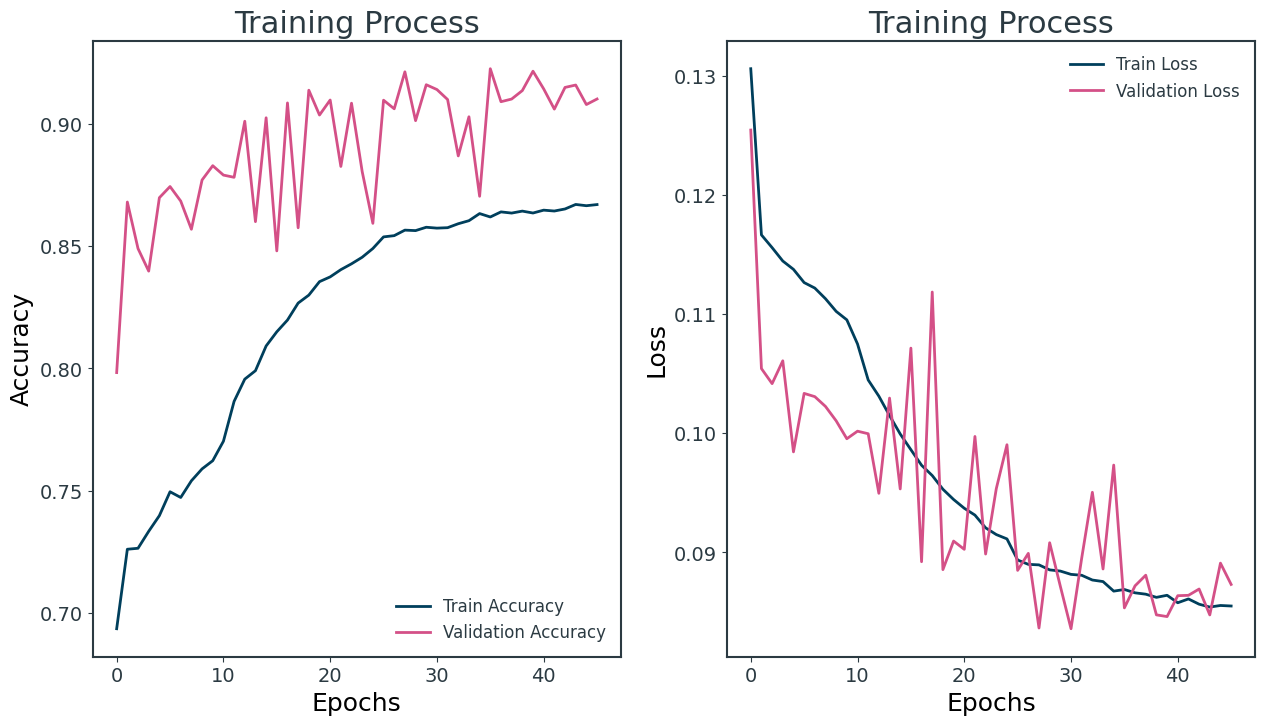

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

history = model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [17]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'lr'])
[0.13061612844467163, 0.1166621744632721, 0.11559351533651352, 0.11446940153837204, 0.11376992613077164, 0.1126590147614479, 0.11219774186611176, 0.11130283772945404, 0.11024080961942673, 0.10952945053577423, 0.10750594735145569, 0.10448279231786728, 0.10312075912952423, 0.10149284452199936, 0.0999462679028511, 0.09862791001796722, 0.09732010960578918, 0.0964575782418251, 0.09530577063560486, 0.09444623440504074, 0.09371019899845123, 0.09313471615314484, 0.09206569194793701, 0.09150069206953049, 0.09113674610853195, 0.08936500549316406, 0.08899884670972824, 0.088955357670784, 0.08853541314601898, 0.08843573182821274, 0.08815772086381912, 0.08808271586894989, 0.08768335729837418, 0.08755398541688919, 0.08675126731395721, 0.08688845485448837, 0.08660796284675598, 0.08649466931819916, 0.08622843027114868, 0.08640266209840775, 0.08577525615692139, 0.08609592169523239, 0.08565385639667511, 0.08541357517242432, 0.0855459

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = model.predict(X_valid)

# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")




16729/16729 [==============================] - 40s 2ms/step
R2 Score: 0.925487783792008
MAE: 0.08359440537259599
